### Reference: https://huggingface.co/transformers/pretrained_models.html

In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Installing the Hugging Face Library

#### https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification

In [0]:
!pip install transformers

In [0]:
pip install nltk

In [0]:
pip install sklearn

In [0]:
import pandas
import nltk
import sklearn
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

In [17]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


#### 3.1. BERT Tokenizer

In [0]:
import io
df = pandas.read_csv(io.BytesIO(uploaded['train.csv']))
corpus = df.text.values
labels = df.target.values

In [19]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# 'bert-base-uncased': 

# Measure the maximum sentence length.
# This will be the hyperparameter for Pad & truncate all sentences.
max_len = 0
for doc in corpus:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(doc, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len) 

Loading BERT tokenizer...
Max sentence length:  84


In [24]:
input_ids = []
attention_masks = []

# Prepend the `[CLS]` token to the start.
# Append the `[SEP]` token to the end.
# Map tokens to their IDs.
# Pad or truncate the sentence to `max_length`
# reate attention masks for [PAD] tokens.

for doc in corpus:
    encoded_dict = tokenizer.encode_plus(
                        doc,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 84,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', corpus[0])
print('Token IDs:', input_ids[0])

Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [25]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,329 training samples
2,284 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32


train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

#
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size 
        )

#### Build BertForSequenceClassification

In [27]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12-layer, 768-hidden, 12-heads, 110M parameters.
                         # Trained on lower-cased English text.
                         # https://huggingface.co/transformers/pretrained_models.html

    num_labels = 2, # 2 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Optimizer & Learning Rate Scheduler

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

In [0]:
import numpy as np

# Calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

### Fine-tune the model

In [33]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

  
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        

    print("")
    print("Running Validation...")

    t0 = time.time()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        


            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    167.    Elapsed: 0:00:35.
  Batch    80  of    167.    Elapsed: 0:01:09.
  Batch   120  of    167.    Elapsed: 0:01:43.
  Batch   160  of    167.    Elapsed: 0:02:17.

  Average training loss: 0.45
  Training epcoh took: 0:02:23

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.41
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:34.
  Batch    80  of    167.    Elapsed: 0:01:08.
  Batch   120  of    167.    Elapsed: 0:01:42.
  Batch   160  of    167.    Elapsed: 0:02:17.

  Average training loss: 0.32
  Training epcoh took: 0:02:22

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.41
  Validation took: 0:00:22

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:34.
  Batch    80  of    167.    Elapsed: 0:01:09.
  Batch   120  of    167.    Elapsed: 0:01:43.
  Batch   160  of    167.    Elapsed: 0:02:17.

  Average training loss: 0.25
  Training ep

In [34]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.45,0.41,0.82,0:02:23,0:00:22
2,0.32,0.41,0.83,0:02:22,0:00:22
3,0.25,0.44,0.83,0:02:23,0:00:22
4,0.19,0.47,0.83,0:02:23,0:00:22


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


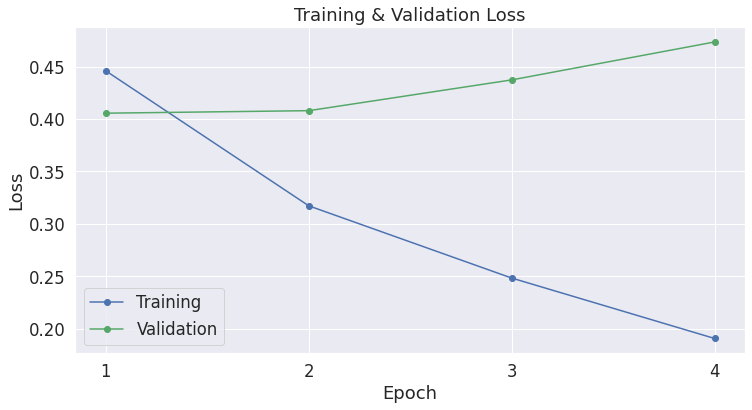

In [35]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Evaluation

In [41]:
model.eval()

test_loader = DataLoader(dataset, batch_size=32)
predictions_list = []

for step, batch in enumerate(test_loader):
    if step % 40 == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    loss, logits = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits , axis=1).flatten()
    predictions_list.append(pred_flat)

  Batch    40  of    167.
  Batch    80  of    167.
  Batch   120  of    167.
  Batch   160  of    167.
  Batch   200  of    167.


In [42]:
y_prediction = []
for pred in predictions_list:
    y_prediction += pred.tolist()


acc = accuracy_score(labels, y_prediction)
roc = roc_auc_score(labels, y_prediction)
f1 = f1_score(labels, y_prediction)

print('BERT accuracy:', round(acc, 4))
print('BERT AUC:', round(roc, 4))
print('BERT F1:', round(f1, 4))

BERT accuracy: 0.9123
BERT AUC: 0.9079
BERT F1: 0.8957
